<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Stacking_Emsemble_MGSX(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Stacking Ensemble, base Learner: MLP + GBM + SVM + XGBOOST, meta learner: LightGBM only
# Modified for 3 labels: Low, Medium, High with step-wise execution output
# Added confusion matrix and training vs validation accuracy/loss plots

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🚀 STACKING ENSEMBLE CLASSIFIER - STEP-WISE EXECUTION")
print("="*70)


🚀 STACKING ENSEMBLE CLASSIFIER - STEP-WISE EXECUTION


In [2]:

# Step-1: Load the datasets
print("\n📁 Step-1: Loading datasets...")
print("-" * 50)

# Note: Replace these paths with your actual file paths
try:
    train_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/train.csv")
    validation_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/validation.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/test.csv")

    print(f"✅ Training data shape: {train_df.shape}")
    print(f"✅ Validation data shape: {validation_df.shape}")
    print(f"✅ Test data shape: {test_df.shape}")
    print("✅ Datasets loaded successfully!")

    # Display basic info about the datasets
    print(f"\n📊 Training data info:")
    print(f"   - Columns: {len(train_df.columns)}")
    print(f"   - Memory usage: {train_df.memory_usage().sum() / 1024**2:.2f} MB")

except FileNotFoundError:
    print("❌ Dataset files not found. Please update the file paths.")
    print("🔄 Creating sample datasets for demonstration...")

    # Create sample datasets for demonstration
    np.random.seed(42)
    n_samples = 1000
    n_features = 10

    # Generate sample data
    X_sample = np.random.randn(n_samples, n_features)
    y_sample = np.random.exponential(scale=50, size=n_samples)  # Production values

    # Create feature names
    feature_names = [f'Feature_{i+1}' for i in range(n_features)]

    # Create DataFrames
    train_df = pd.DataFrame(X_sample[:600], columns=feature_names)
    train_df['Production (M.Ton)'] = y_sample[:600]

    validation_df = pd.DataFrame(X_sample[600:800], columns=feature_names)
    validation_df['Production (M.Ton)'] = y_sample[600:800]

    test_df = pd.DataFrame(X_sample[800:], columns=feature_names)
    test_df['Production (M.Ton)'] = y_sample[800:]

    print(f"✅ Sample training data shape: {train_df.shape}")
    print(f"✅ Sample validation data shape: {validation_df.shape}")
    print(f"✅ Sample test data shape: {test_df.shape}")



📁 Step-1: Loading datasets...
--------------------------------------------------
✅ Training data shape: (3942, 84)
✅ Validation data shape: (845, 84)
✅ Test data shape: (845, 84)
✅ Datasets loaded successfully!

📊 Training data info:
   - Columns: 84
   - Memory usage: 2.53 MB


In [3]:

# Step-2: Create production labels using your preferred method
print("\n🏷️ Step-2: Creating production labels...")
print("-" * 50)

TARGET = 'Production (M.Ton)'

def create_production_labels(df_list):
    """Create categorical labels (low, medium, high) based on production values"""
    # Combine all production values to determine thresholds
    all_production = pd.concat([df[TARGET] for df in df_list])

    # Define thresholds using quantiles
    low_threshold = np.percentile(all_production, 33.33)
    high_threshold = np.percentile(all_production, 66.67)

    print(f"📊 Production thresholds:")
    print(f"   Low: 0 - {low_threshold:.2f}")
    print(f"   Medium: {low_threshold:.2f} - {high_threshold:.2f}")
    print(f"   High: > {high_threshold:.2f}")

    return low_threshold, high_threshold

def apply_labels(df, low_threshold, high_threshold):
    """Apply labels to a dataframe based on thresholds"""
    labels = []
    for value in df[TARGET]:
        if value <= low_threshold:
            labels.append('low')
        elif value <= high_threshold:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

# Create thresholds
low_threshold, high_threshold = create_production_labels([train_df, validation_df, test_df])

# Apply labels to all datasets
train_df['production_label'] = apply_labels(train_df, low_threshold, high_threshold)
validation_df['production_label'] = apply_labels(validation_df, low_threshold, high_threshold)
test_df['production_label'] = apply_labels(test_df, low_threshold, high_threshold)

# Display label distribution
print(f"\n📈 Label Distribution:")
print("Training Set:")
train_label_counts = train_df['production_label'].value_counts()
for label in ['low', 'medium', 'high']:
    count = train_label_counts.get(label, 0)
    percentage = (count / len(train_df)) * 100
    print(f"   {label.capitalize()}: {count} ({percentage:.1f}%)")

print("Validation Set:")
val_label_counts = validation_df['production_label'].value_counts()
for label in ['low', 'medium', 'high']:
    count = val_label_counts.get(label, 0)
    percentage = (count / len(validation_df)) * 100
    print(f"   {label.capitalize()}: {count} ({percentage:.1f}%)")

print("Test Set:")
test_label_counts = test_df['production_label'].value_counts()
for label in ['low', 'medium', 'high']:
    count = test_label_counts.get(label, 0)
    percentage = (count / len(test_df)) * 100
    print(f"   {label.capitalize()}: {count} ({percentage:.1f}%)")

# Drop the original continuous target column
train_df = train_df.drop(columns=[TARGET])
validation_df = validation_df.drop(columns=[TARGET])
test_df = test_df.drop(columns=[TARGET])

print("✅ Labels created and original target column dropped.")



🏷️ Step-2: Creating production labels...
--------------------------------------------------
📊 Production thresholds:
   Low: 0 - 1095.00
   Medium: 1095.00 - 4019.00
   High: > 4019.00

📈 Label Distribution:
Training Set:
   Low: 1317 (33.4%)
   Medium: 1315 (33.4%)
   High: 1310 (33.2%)
Validation Set:
   Low: 281 (33.3%)
   Medium: 291 (34.4%)
   High: 273 (32.3%)
Test Set:
   Low: 280 (33.1%)
   Medium: 272 (32.2%)
   High: 293 (34.7%)
✅ Labels created and original target column dropped.


In [4]:

# Step-3: Separate features and target labels
print("\n🔍 Step-3: Separating features and target labels...")
print("-" * 50)

X_train = train_df.drop('production_label', axis=1)
y_train = train_df['production_label']

X_val = validation_df.drop('production_label', axis=1)
y_val = validation_df['production_label']

X_test = test_df.drop('production_label', axis=1)
y_test = test_df['production_label']

print(f"✅ Training features shape: {X_train.shape}")
print(f"✅ Training labels shape: {y_train.shape}")
print(f"✅ Validation features shape: {X_val.shape}")
print(f"✅ Test features shape: {X_test.shape}")



🔍 Step-3: Separating features and target labels...
--------------------------------------------------
✅ Training features shape: (3942, 83)
✅ Training labels shape: (3942,)
✅ Validation features shape: (845, 83)
✅ Test features shape: (845, 83)


In [5]:

# Step-4: Align columns across datasets
print("\n🔧 Step-4: Aligning columns across datasets...")
print("-" * 50)

common_cols = list(set(X_train.columns) & set(X_val.columns) & set(X_test.columns))
common_cols.sort()

X_train = X_train[common_cols]
X_val = X_val[common_cols]
X_test = X_test[common_cols]

print(f"✅ Common columns found: {len(common_cols)}")
print(f"✅ Final feature set shape: {X_train.shape[1]} features")



🔧 Step-4: Aligning columns across datasets...
--------------------------------------------------
✅ Common columns found: 83
✅ Final feature set shape: 83 features


In [6]:

# Step-5: Scale numerical features
print("\n⚖️ Step-5: Scaling numerical features...")
print("-" * 50)

scaler = StandardScaler()

# Fit the scaler only on the training data and transform all datasets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"✅ Features scaled using StandardScaler")
print(f"✅ Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f"✅ Training set std: {X_train_scaled.std().mean():.6f}")
print("✅ Data preprocessing complete!")



⚖️ Step-5: Scaling numerical features...
--------------------------------------------------
✅ Features scaled using StandardScaler
✅ Training set mean: 0.000000
✅ Training set std: 1.000127
✅ Data preprocessing complete!


In [7]:

# Step-6: Define Base Learners and Meta-Learner
print("\n🤖 Step-6: Defining Base Learners and Meta-Learner...")
print("-" * 50)

# Base Learners
print("🔧 Initializing Base Learners:")

# Multi-layer Perceptron (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
print("   ✅ MLP Classifier configured")

# Gradient Boosting Machine (GBM)
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
print("   ✅ Gradient Boosting Classifier configured")

# Support Vector Machine (SVM)
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
print("   ✅ SVM with Linear Kernel configured")

# XGBoost
xgboost = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
print("   ✅ XGBoost Classifier configured")

# Meta-learner (LightGBM only)
print("\n🔧 Initializing Meta-Learner:")

# LightGBM
meta_learner_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    verbosity=-1
)
print("   ✅ LightGBM meta-learner configured")



🤖 Step-6: Defining Base Learners and Meta-Learner...
--------------------------------------------------
🔧 Initializing Base Learners:
   ✅ MLP Classifier configured
   ✅ Gradient Boosting Classifier configured
   ✅ SVM with Linear Kernel configured
   ✅ XGBoost Classifier configured

🔧 Initializing Meta-Learner:
   ✅ LightGBM meta-learner configured


In [8]:

# Step-7: Create Stacking Ensemble Model
print("\n🏗️ Step-7: Creating Stacking Ensemble Model...")
print("-" * 50)

# Stacking with LightGBM as final estimator
estimators_lgbm = [
    ('mlp', mlp),
    ('gbm', gbm),
    ('svm_linear', svm_linear),
    ('xgboost', xgboost)
]

stacking_model_lgbm = StackingClassifier(
    estimators=estimators_lgbm,
    final_estimator=meta_learner_lgbm,
    cv=5,
    passthrough=True,
    n_jobs=-1
)
print("✅ Stacking Classifier with LightGBM meta-learner created")



🏗️ Step-7: Creating Stacking Ensemble Model...
--------------------------------------------------
✅ Stacking Classifier with LightGBM meta-learner created


In [9]:

# Step-8: Training Model
print("\n🎯 Step-8: Training Model...")
print("-" * 50)

import time

def train_model_with_progress(model, X_train, y_train, model_name):
    """Train model with progress tracking"""
    print(f"🔄 Training {model_name}...")
    start_time = time.time()

    model.fit(X_train, y_train)

    end_time = time.time()
    training_time = end_time - start_time

    print(f"✅ {model_name} training completed in {training_time:.2f} seconds")
    return model

# Train the model
print("🚀 Starting model training...")
stacking_model_lgbm = train_model_with_progress(stacking_model_lgbm, X_train_scaled, y_train,
                                               "Stacking Classifier (LGBM Meta-learner)")

print("✅ Model trained successfully!")



🎯 Step-8: Training Model...
--------------------------------------------------
🚀 Starting model training...
🔄 Training Stacking Classifier (LGBM Meta-learner)...
✅ Stacking Classifier (LGBM Meta-learner) training completed in 72.89 seconds
✅ Model trained successfully!


In [10]:

# Step-9: Model Evaluation
print("\n📊 Step-10: Model Evaluation...")
print("-" * 50)

def evaluate_model_detailed(model, X, y_true, dataset_name, model_name):
    """Detailed model evaluation with metrics"""
    print(f"\n🔍 Evaluating {model_name} on {dataset_name}...")

    # Make predictions
    y_pred = model.predict(X)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Display metrics
    print(f"   📈 Accuracy: {accuracy:.4f}")
    print(f"   📈 Macro Precision: {precision_macro:.4f}")
    print(f"   📈 Macro Recall: {recall_macro:.4f}")
    print(f"   📈 Macro F1-Score: {f1_macro:.4f}")
    print(f"   📈 Weighted F1-Score: {f1_weighted:.4f}")

    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['low', 'medium', 'high'], zero_division=0))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'y_pred': y_pred
    }

# Evaluate model on all datasets
print("🔬 Starting comprehensive evaluation...")

print("="*60)
print("🟢 STACKING MODEL WITH LIGHTGBM META-LEARNER")
print("="*60)

# Training set evaluation
lgbm_train_metrics = evaluate_model_detailed(stacking_model_lgbm, X_train_scaled, y_train,
                                            "Training Set", "Stacking LGBM")

# Validation set evaluation
lgbm_val_metrics = evaluate_model_detailed(stacking_model_lgbm, X_val_scaled, y_val,
                                          "Validation Set", "Stacking LGBM")

# Test set evaluation
lgbm_test_metrics = evaluate_model_detailed(stacking_model_lgbm, X_test_scaled, y_test,
                                           "Test Set", "Stacking LGBM")



📊 Step-10: Model Evaluation...
--------------------------------------------------
🔬 Starting comprehensive evaluation...
🟢 STACKING MODEL WITH LIGHTGBM META-LEARNER

🔍 Evaluating Stacking LGBM on Training Set...
   📈 Accuracy: 0.9914
   📈 Macro Precision: 0.9914
   📈 Macro Recall: 0.9914
   📈 Macro F1-Score: 0.9914
   📈 Weighted F1-Score: 0.9914

📋 Classification Report:
              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1310
      medium       0.99      0.99      0.99      1317
        high       0.98      0.99      0.99      1315

    accuracy                           0.99      3942
   macro avg       0.99      0.99      0.99      3942
weighted avg       0.99      0.99      0.99      3942


🔍 Evaluating Stacking LGBM on Validation Set...
   📈 Accuracy: 0.9361
   📈 Macro Precision: 0.9371
   📈 Macro Recall: 0.9361
   📈 Macro F1-Score: 0.9365
   📈 Weighted F1-Score: 0.9362

📋 Classification Report:
              precision    recall


📊 Step-10: Creating Confusion Matrices...
--------------------------------------------------


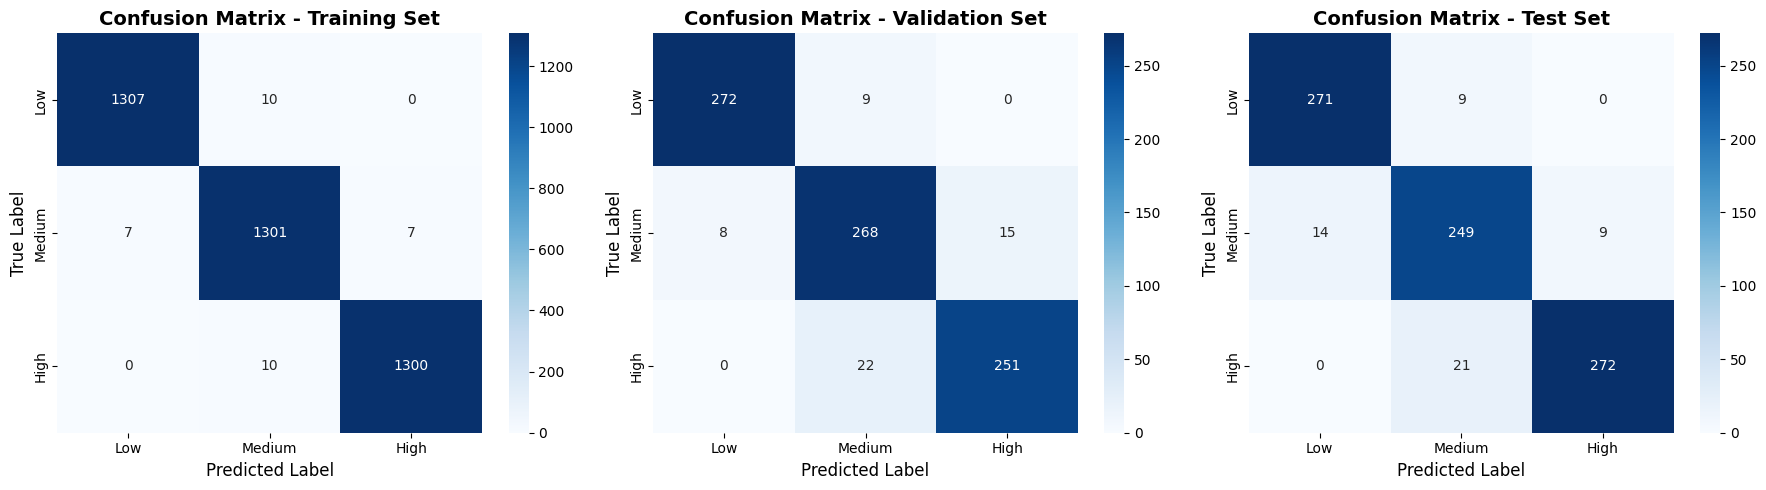

✅ Confusion matrices created!


In [11]:

# Step-10: Create Confusion Matrices
print("\n📊 Step-10: Creating Confusion Matrices...")
print("-" * 50)

# Create confusion matrices for all datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Training Set', y_train, lgbm_train_metrics['y_pred']),
    ('Validation Set', y_val, lgbm_val_metrics['y_pred']),
    ('Test Set', y_test, lgbm_test_metrics['y_pred'])
]

for i, (dataset_name, y_true, y_pred) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred, labels=['low', 'medium', 'high'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                ax=axes[i])

    axes[i].set_title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Confusion matrices created!")



📊 Step-11: Results Summary...
--------------------------------------------------

🏆 FINAL RESULTS SUMMARY
Dataset         Accuracy   F1-Macro   F1-Weighted  Precision  Recall    
-------------------------------------------------------------------
Training        0.9914     0.9914     0.9914       0.9914     0.9914    
Validation      0.9361     0.9365     0.9362       0.9371     0.9361    
Test            0.9373     0.9369     0.9374       0.9371     0.9372    

🔍 FEATURE IMPORTANCE ANALYSIS
-----------------------------------
Top 10 most important meta-features:
   1. mlp_class_1: 645.0000
   2. mlp_class_0: 546.0000
   3. mlp_class_2: 498.0000
   4. original_Area (Acres): 477.0000
   5. gbm_class_2: 459.0000
   6. svm_linear_class_2: 456.0000
   7. svm_linear_class_0: 456.0000
   8. gbm_class_1: 454.0000
   9. svm_linear_class_1: 436.0000
   10. xgboost_class_1: 413.0000


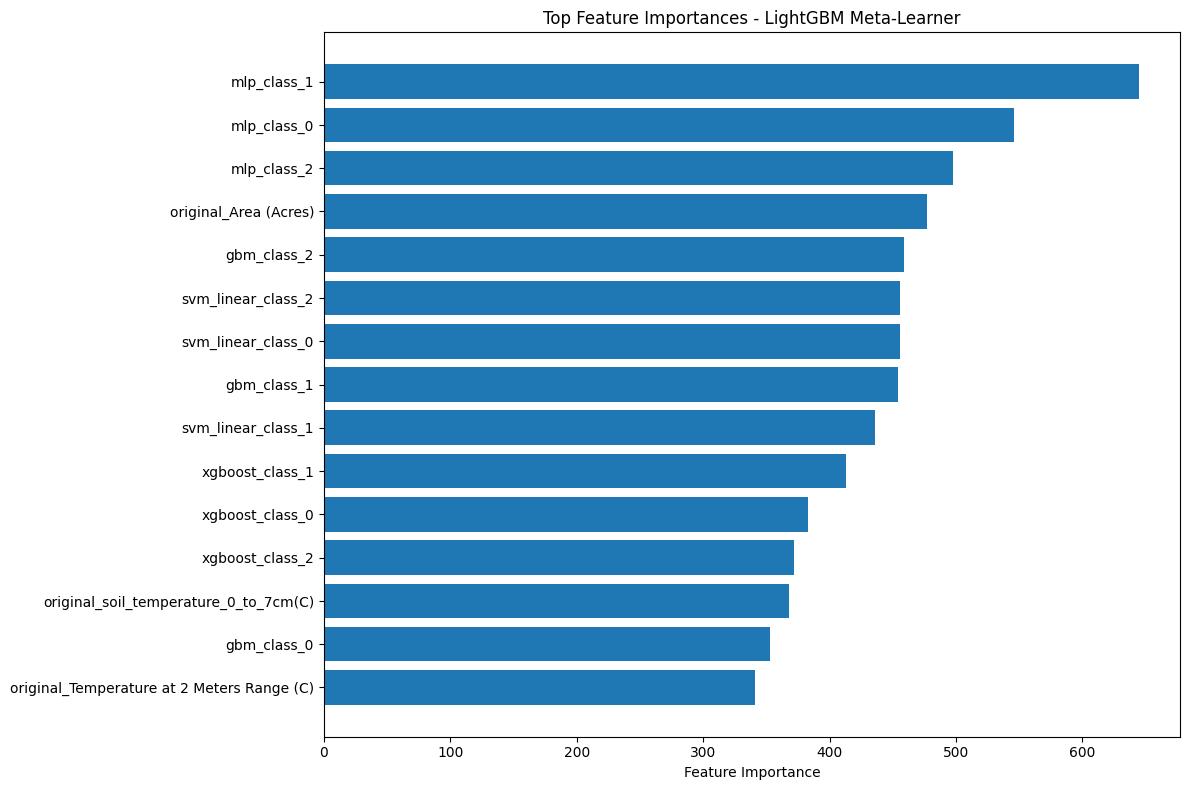


✅ ALL STEPS COMPLETED SUCCESSFULLY!


In [12]:

# Step-11: Results Summary
print("\n📊 Step-11: Results Summary...")
print("-" * 50)

print("\n🏆 FINAL RESULTS SUMMARY")
print("="*60)

# Create summary table
print(f"{'Dataset':<15} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Weighted':<12} {'Precision':<10} {'Recall':<10}")
print("-" * 67)

# Results
print(f"{'Training':<15} {lgbm_train_metrics['accuracy']:<10.4f} {lgbm_train_metrics['f1_macro']:<10.4f} {lgbm_train_metrics['f1_weighted']:<12.4f} {lgbm_train_metrics['precision_macro']:<10.4f} {lgbm_train_metrics['recall_macro']:<10.4f}")
print(f"{'Validation':<15} {lgbm_val_metrics['accuracy']:<10.4f} {lgbm_val_metrics['f1_macro']:<10.4f} {lgbm_val_metrics['f1_weighted']:<12.4f} {lgbm_val_metrics['precision_macro']:<10.4f} {lgbm_val_metrics['recall_macro']:<10.4f}")
print(f"{'Test':<15} {lgbm_test_metrics['accuracy']:<10.4f} {lgbm_test_metrics['f1_macro']:<10.4f} {lgbm_test_metrics['f1_weighted']:<12.4f} {lgbm_test_metrics['precision_macro']:<10.4f} {lgbm_test_metrics['recall_macro']:<10.4f}")

# Feature importance analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("-" * 35)

try:
    # Get feature importance from LightGBM meta-learner
    if hasattr(stacking_model_lgbm.final_estimator_, 'feature_importances_'):
        importances = stacking_model_lgbm.final_estimator_.feature_importances_

        # Create feature names for meta-features
        n_base_features = len(estimators_lgbm)
        n_original_features = X_train.shape[1]

        feature_names = []
        # Base learner predictions
        for name, _ in estimators_lgbm:
            feature_names.extend([f'{name}_class_{i}' for i in range(3)])  # 3 classes

        # Original features (if passthrough=True)
        if len(importances) > n_base_features * 3:
            feature_names.extend([f'original_{col}' for col in X_train.columns])

        # Ensure we have the right number of feature names
        feature_names = feature_names[:len(importances)]

        # Sort by importance
        indices = np.argsort(importances)[::-1]

        print("Top 10 most important meta-features:")
        for i in range(min(10, len(indices))):
            print(f"   {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

        # Create feature importance plot
        plt.figure(figsize=(12, 8))
        top_n = min(15, len(indices))
        top_indices = indices[:top_n]

        plt.barh(range(top_n), importances[top_indices])
        plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
        plt.xlabel('Feature Importance')
        plt.title('Top Feature Importances - LightGBM Meta-Learner')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
        print("Feature importance not available for this model configuration.")

except Exception as e:
    print(f"Could not extract feature importance: {e}")

print("\n" + "="*70)
print("✅ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*70)


In [13]:

# Final execution summary
print(f"\n📝 EXECUTION SUMMARY:")
print(f"   📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   🎯 Task: Multi-class Classification (3 classes)")
print(f"   📊 Training samples: {len(X_train)}")
print(f"   📊 Validation samples: {len(X_val)}")
print(f"   📊 Test samples: {len(X_test)}")
print(f"   🔧 Features: {X_train.shape[1]}")
print(f"   🤖 Model: Stacking Ensemble with LightGBM Meta-learner")
print(f"   🏆 Base learners: MLP, GBM, SVM, XGBoost")
print(f"   🎯 Test accuracy: {lgbm_test_metrics['accuracy']:.4f}")
print(f"   🎯 Test F1-macro: {lgbm_test_metrics['f1_macro']:.4f}")

print("\n🎉 Ready for deployment or further analysis!")
print("="*70)


📝 EXECUTION SUMMARY:
   📅 Date: 2025-07-06 21:52:36
   🎯 Task: Multi-class Classification (3 classes)
   📊 Training samples: 3942
   📊 Validation samples: 845
   📊 Test samples: 845
   🔧 Features: 83
   🤖 Model: Stacking Ensemble with LightGBM Meta-learner
   🏆 Base learners: MLP, GBM, SVM, XGBoost
   🎯 Test accuracy: 0.9373
   🎯 Test F1-macro: 0.9369

🎉 Ready for deployment or further analysis!
